# 공통사항

## Import Library

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## Data Load

In [2]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

## Data Preprocessing

In [3]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# 데이터를 동일하게 처리해주기 유용함.
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [4]:
# 필요 없어 보이는 columns 제거
drop_col = ['부번', '계약일', 'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'k-관리비부과면적', '주차대수', '건축면적', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', '중개사소재지', '등기신청일자']
df.drop(drop_col, axis=1, inplace=True)

In [5]:
df['구'] = df['시군구'].apply(lambda x:x.split()[1])
df['동'] = df['시군구'].apply(lambda x:x.split()[2])

omg = ['용산구', '강남구', '서초구', '송파구', '성동구', '종로구']
is_omg = []
for x in df['구'].tolist():
    if x in omg:
        is_omg.append(1)
    else:
        is_omg.append(0)
df['개비싸'] = is_omg
# 이렇게 말고 '동' 을 분류하지 않아도 될듯       
df.loc[~df['구'].isin(omg), '동'] = 'Unknown' 

del df['시군구']

In [6]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
df['거래유형'] = df['거래유형'].replace('-', np.nan)

In [7]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
df['본번'] = df['본번'].astype('str')

In [8]:
df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4])
df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:])

In [9]:
# 'time_col' 데이터를 문자열 형태로 변환
df['계약년월'] = df['계약년월'].astype(str)
# 문자열 형태 데이터를 datetime 형태로 변환
df['계약년월'] = pd.to_datetime(df['계약년월'], format='%Y%m')
# 변환 확인
print(df['계약년월'].head())

0   2017-12-01
1   2017-12-01
2   2017-12-01
3   2018-01-01
4   2018-01-01
Name: 계약년월, dtype: datetime64[ns]


In [10]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y', 'target', 'is_test', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '계약년월', '도로명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [11]:
# 수치형 데이터를 어떻게 채워야 될지 모르겠음 -> 걍 빼.
# 좌표X, 좌표Y 를 리니어로 채우는건 혼동을 줄 수 있는 데이터임
df.drop(columns=['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y'], inplace=True)

In [12]:
# 범주형 변수에 대한 보간
df[categorical_columns] = df[categorical_columns].fillna('NULL')

## Feature engineering

In [13]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 19) (9272, 19)


In [14]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
df_test['target'] = 0

In [15]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if column == '계약년월':
        continue
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [16]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 13/13 [00:03<00:00,  3.87it/s]


In [17]:
df_train.head()        # 레이블인코딩이 된 모습입니다.

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,2017-12-01,3,1987,6176,0,3,2,1,241,124000.0,0,3,1,10,11
1,4732,1149,328,79.97,2017-12-01,4,1987,6176,0,3,2,1,241,123500.0,0,3,1,10,11
2,4732,1149,328,54.98,2017-12-01,5,1987,6176,0,3,2,1,241,91500.0,0,3,1,10,11
3,4732,1149,328,79.97,2018-01-01,4,1987,6176,0,3,2,1,241,130000.0,0,3,1,11,0
4,4732,1149,328,79.97,2018-01-01,2,1987,6176,0,3,2,1,241,117000.0,0,3,1,11,0


# Model Training

- 시간을 고려하여 dataset split 을 진행합니다.

In [18]:
assert df_train.shape[1] == df_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [19]:
df_train.head()

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,2017-12-01,3,1987,6176,0,3,2,1,241,124000.0,0,3,1,10,11
1,4732,1149,328,79.97,2017-12-01,4,1987,6176,0,3,2,1,241,123500.0,0,3,1,10,11
2,4732,1149,328,54.98,2017-12-01,5,1987,6176,0,3,2,1,241,91500.0,0,3,1,10,11
3,4732,1149,328,79.97,2018-01-01,4,1987,6176,0,3,2,1,241,130000.0,0,3,1,11,0
4,4732,1149,328,79.97,2018-01-01,2,1987,6176,0,3,2,1,241,117000.0,0,3,1,11,0


In [23]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023, shuffle=False)

In [25]:
print(f"Train set Date Range :")
display(X_train['계약년월'].sort_values(ascending=True).head().to_list())
print('...')
display(X_train['계약년월'].sort_values(ascending=False).head().to_list())

print(f"Valid set Date Range :")
display(X_val['계약년월'].sort_values(ascending=True).head().to_list())
print('...')
display(X_val['계약년월'].sort_values(ascending=False).head().to_list())

# 이제 train_df와 validation_df를 사용하여 모델 훈련 및 검증을 진행할 수 있습니다.
del X_train['계약년월']
del X_val['계약년월']

Train set Date Range :


[Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00')]

...


[Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00')]

Valid set Date Range :


[Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00')]

...


[Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00')]

In [26]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [27]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 31793.55624212955


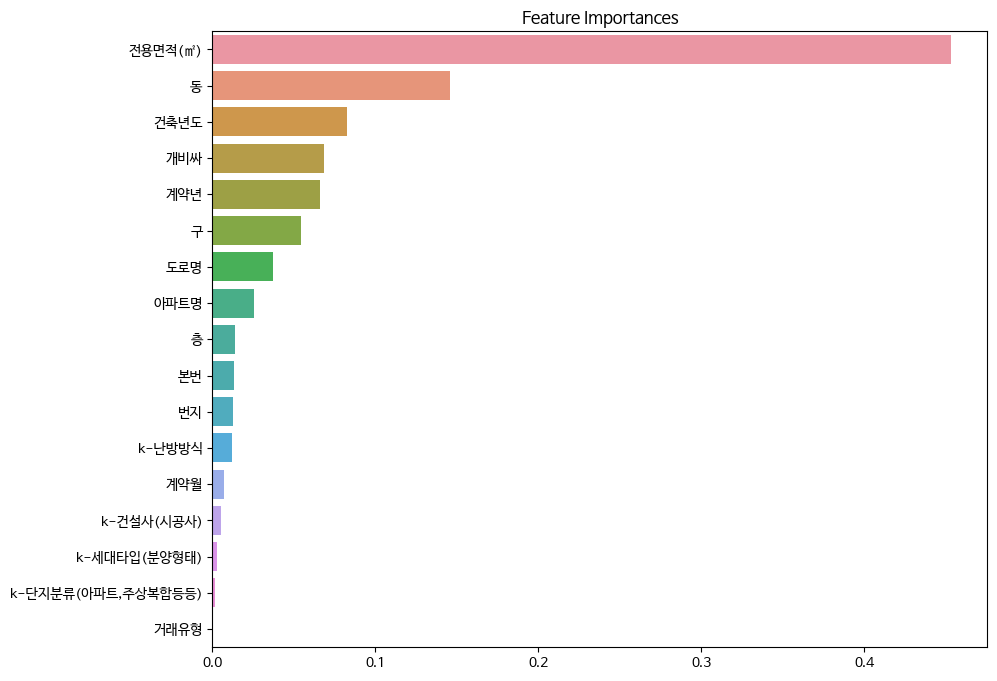

In [28]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [28]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 1,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
2395092521.6480 ± 14570972.8302,전용면적(㎡)
1377328883.7103 ± 9760382.4470,동
1204774704.1579 ± 11411017.7977,건축년도
1001179445.6809 ± 12568722.8024,구
617076457.0450 ± 5889063.7750,개비싸
502704847.9954 ± 3413361.9799,도로명
271527088.1961 ± 2602397.5513,아파트명
171461126.9147 ± 61563.6857,k-난방방식
149018361.3732 ± 4346948.2276,번지
117328327.1713 ± 1466016.8066,본번


In [29]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

X_val_sort.head()

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월,target,pred,error
236663,3294,854,5695,268.670,5,2020,7150,2,0,0,0,73,20,112,1,15,3,1350000.0,342000.0,1.016064e+12
224567,745,222,112,273.960,16,2020,5895,2,0,0,0,73,0,97,1,15,3,1450000.0,516068.2,8.722286e+11
233420,4859,1179,4041,264.546,47,2020,6844,1,0,0,0,73,15,48,1,15,8,1300000.0,370056.2,8.647955e+11
236662,3294,854,5695,268.950,2,2020,7149,2,0,0,0,73,20,112,1,14,11,1200000.0,374813.6,6.809326e+11
236661,3294,854,5695,268.670,4,2020,7149,2,0,0,0,73,20,112,1,14,10,1170000.0,374813.6,6.323214e+11


In [33]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])
    
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월,target,pred,error
236663,410,410.0,파르크한남,268.67,5,2020,유엔빌리지길 80-36,직거래,NULL,NULL,NULL,NULL,용산구,한남동,1,2022,04,1350000.0,342000.0,1.016064e+12


,번지,본번,아파트명,전용면적(㎡),층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),구,동,개비싸,계약년,계약월,target,pred,error
420602,200,200.0,독립문극동,59.58,15,1998,독립문공원길 17,NULL,아파트,분양,개별난방,극동건설(주),서대문구,Unknown,0,2019,09,67000.0,67000.0,0.0


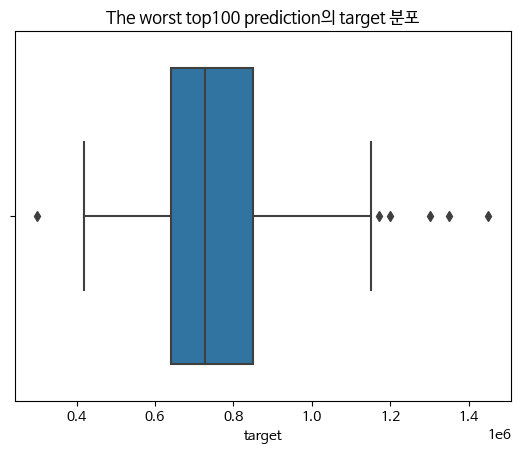

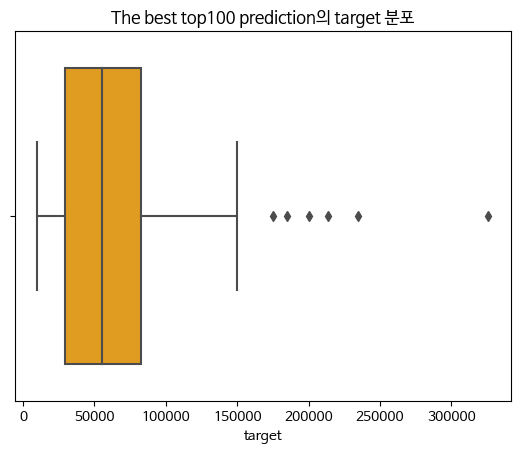

In [34]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

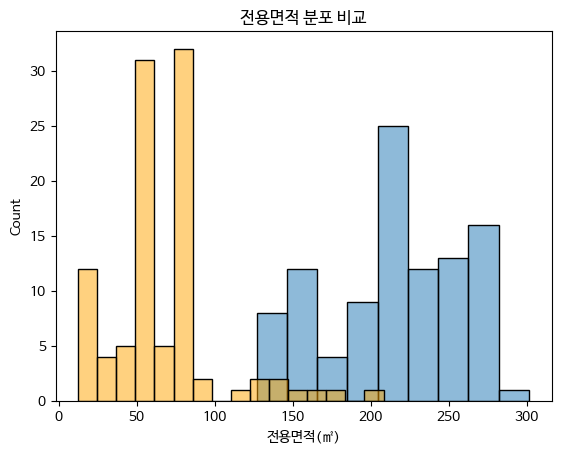

In [35]:
sns.histplot(data = error_top100, x='전용면적(㎡)', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적(㎡)', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

In [ ]:
del df_test['계약년월']

In [39]:
%%time
X_test = df_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 22.5 ms, sys: 3.5 ms, total: 26 ms
Wall time: 17.4 ms


In [40]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)